# Image superresolution


In [224]:
#load the libraries

import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.functional as TF
import math
import random

import torch
from torch import nn
from torch import optim

from piq import ssim, SSIMLoss
from piq import gmsd, GMSDLoss
from piq import mdsi, MDSILoss

# Defining the data generator class

*The datagenerator is modified to accept two datasets( high res images, low res images )*
*The datagenerator applies similar transformation to both the datasets*


In [225]:
class TrainDataset(Dataset):
    
  #Args:
  #      image_dir (str): Train/Valid dataset address.
  #      upscale_factor (int): Image up scale factor.
  #      image_size (int): High resolution image size.
    
  def __init__(self,low_image_dir,high_image_dir,transforms=None):
    super(TrainDataset, self).__init__()

    self.transforms = transforms
    
    # Preloading the data 
    lowimagelist = sorted(os.listdir(low_image_dir))
    low_image_file_names = [os.path.join(low_image_dir, low_image_file_name) for low_image_file_name in lowimagelist]
    self.low_images = []
    for lowfilename in low_image_file_names:
        #print(lowfilename)
        self.low_images.append(read_image(lowfilename)/255.)
    
    #preloading highres image data
    highimagelist = sorted(os.listdir(high_image_dir))
    high_image_file_names = [os.path.join(high_image_dir, high_image_file_name) for high_image_file_name in highimagelist]
    self.high_images = []
    for highfilename in high_image_file_names:
        self.high_images.append(read_image(highfilename)/255.)
    
  def __len__(self):
        return len(self.low_images)
    
  def custom_segmentation_transforms(self,HRimage, LRimage):
    if random.random() < 0.2:
        angle = random.randint(-5, 5)
        HRimage = TF.rotate(HRimage, angle)
        LRimage = TF.rotate(LRimage, angle)
    if (random.random() > 0.2) & (random.random() < 0.4):
        HRimage = HRimage
        LRimage = LRimage
    else:
        angle = random.randint(-5, 5)
        HRimage = TF.rotate(HRimage, angle)
        LRimage = TF.rotate(LRimage, angle)
    return HRimage, LRimage


  def __getitem__(self, batch_index: int):

    if self.transforms == None:
        hr_image = self.high_images[batch_index]
        lr_image = self.low_images[batch_index]
        #resize1 = T.Resize((128,128),interpolation=InterpolationMode.BILINEAR,antialias=True)
        #resize2 = T.Resize((64,64),interpolation=InterpolationMode.BILINEAR,antialias=True) 
    else:
        hr_image,lr_image = self.custom_segmentation_transforms(self.high_images[batch_index],self.low_images[batch_index])
        #resize1 = T.Resize((128,128),interpolation=InterpolationMode.BILINEAR,antialias=True)
        #resize2 = T.Resize((64,64),interpolation=InterpolationMode.BILINEAR,antialias=True) 
    return hr_image, lr_image


## Declare paths for training and testing

In [231]:
dataset = TrainDataset('/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/SRGAN_dataset_all/LR_training_dataset','/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/SRGAN_dataset_all/HR_ground_truth_training', True)
testdataset = TrainDataset('/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/SRGAN_dataset_all/LR_testing_dataset','/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/SRGAN_dataset_all/HR_ground_truth_testing', True)

trainloader = DataLoader(dataset,shuffle=True)
testloader = DataLoader(testdataset,shuffle=True)
PATH = '/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/Models/500_SSIM.h5'
root = '/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/NetworkOutput'

In [232]:
len(testdataset)

256

# Display a random batch of training patches. 

Since shuffle is true, running multiple times will display multiple images with random crops and flips, specified by the transform

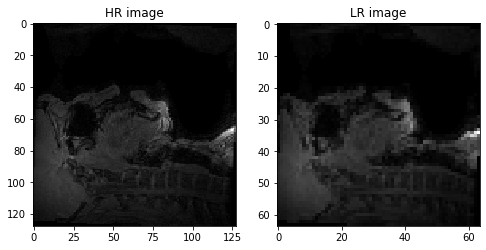

In [233]:
hr_image, lr_image= next(iter(trainloader))
fig, ax = plt.subplots(1,2,figsize=(8,4))
hr_image = np.transpose(np.asarray(hr_image[0]),(1,2,0))
lr_image = np.transpose(np.asarray(lr_image[0]),(1,2,0))
                        
rgb_hr_image = np.stack((hr_image,hr_image, hr_image), axis=2)
rgb_lr_image = np.stack((lr_image,lr_image, lr_image), axis=2)
                        
s=ax[0].imshow(np.squeeze(rgb_hr_image))
s=ax[0].set_title('HR image')
s=ax[1].imshow(np.squeeze(rgb_lr_image))
s=ax[1].set_title('LR image')


# <font color=red>SRResnet module </font>

In [234]:
# Residual blocks
class ResidualBlock(nn.Module):
  def __init__(self, nBaseChannels):
    super(ResidualBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=nBaseChannels,out_channels=nBaseChannels,kernel_size=3,stride=1,padding=1, bias=False)
    self.in1 = nn.InstanceNorm2d(nBaseChannels, affine=True)
    self.relu = nn.LeakyReLU(0.2, inplace=True)
    self.conv2 = nn.Conv2d(in_channels=nBaseChannels, out_channels=nBaseChannels, kernel_size=3, stride=1, padding=1, bias=False)
    self.in2 = nn.InstanceNorm2d(nBaseChannels, affine=True)
  
  def forward(self, x):
    input_data = x
    output = self.relu(self.in1(self.conv1(x)))
    #print(input_data.shape)
    output = self.in2(self.conv2(output))
    output = torch.add(output, input_data)
    #print(output.shape)
    return output
    

In [235]:
#SR Resnet module
class SRResnet(nn.Module):
    def __init__(self,nBaseChannels,upSamplingFactor) -> None:
      super(SRResnet, self).__init__()
      
      # Feature extraction layer.
      self.features = nn.Sequential(
        nn.Upsample(scale_factor=upSamplingFactor),  
        nn.Conv2d(1, nBaseChannels, 9,1,4),
        nn.ReLU(True)
      )

      # Non-linear mapping layer.
      self.map = nn.Sequential(
        nn.Conv2d(nBaseChannels, nBaseChannels, 5,1,2),
        nn.ReLU(True),
      )
      # Resnet blocks
      self.Resnet = nn.Sequential(
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels)
      )

      # Reconstruction layer.
      self.reconstruction = nn.Conv2d(nBaseChannels, 1, 5,1,2)

      # Initialize model weights.
      self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = self.features(x)
      #out = self.map(out)
      out = self.Resnet(out)
      out = self.reconstruction(out)
      return torch.clip(out,min=0,max=1)

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
      for module in self.modules():
          if isinstance(module, nn.Conv2d):
              torch.nn.init.xavier_uniform_(module.weight)
              #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
              #nn.init.zeros_(module.bias.data)

      nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
      nn.init.zeros_(self.reconstruction.bias.data)

## Training the model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
upSamplingFactor = 2
Net = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)

#lossfn = torch.nn.MSELoss()
lossfn = SSIMLoss()

optimizer = optim.Adam(Net.parameters(), lr=0.00001)
best_loss = np.float('inf')
for epoch in range(500):
  epochloss = 0
  for hr_image, lr_image in trainloader:
    out = Net(lr_image.to(device))
    cost =lossfn(out,hr_image.to(device))
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    epochloss += cost
  if np.mod(epoch,10)==0:
    print(epochloss.item()/dataset.__len__())
    if epochloss < best_loss:
        torch.save(Net.state_dict(),PATH)
        best_loss = epochloss

0.3178091049194336


## Quantitative evaluation


In [ ]:
#declaring all the loss functions
L1= torch.nn.L1Loss()
MSE = torch.nn.MSELoss()
SSIM = SSIMLoss()
nll_loss = nn.NLLLoss()
upSamplingFactor = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hr_image, lr_image, = testdataset.__getitem__(18)
hr_image = hr_image.unsqueeze(0)

# Image size may not be divisible by upSamplingFactor; resizing the original image
imsize = list(hr_image.shape[-2:])
imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

#Generating output from the network
model = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)
model.load_state_dict(torch.load(PATH))
out = model(lr_image.to(device)).detach().cpu()
sz = out.shape

# Generating the error matrics
print('comparison using error matrics')
print('L1 loss HR vs SuperRes: ',L1(out,hr_image[:,:,:sz[2],:sz[3]]).item())
print('L1 loss HR vs Bilinear: ',L1(bilinear,hr_image[:,:,:sz[2],:sz[3]]).item())
print('\n')
print('MSE loss HR vs SuperRes: ',MSE(out,hr_image[:,:,:sz[2],:sz[3]]).item())
print('MSE loss HR vs Bilinear: ',MSE(bilinear,hr_image[:,:,:sz[2],:sz[3]]).item())

# Visual evaluation on test data


In [ ]:

hr_image, lr_image = testdataset.__getitem__(18)
hr_image = hr_image.unsqueeze(0)

# Image size may not be divisible by upSamplingFactor; resizing the original image
imsize = list(hr_image.shape[-2:])
imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

# Evaluation
model = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)
model.load_state_dict(torch.load(PATH))
out = model(lr_image.to(device)).detach().cpu()

#plotting the figures
fig, ax = plt.subplots(1,3,figsize=(24,8))
hr_image = np.transpose(np.asarray(hr_image[0]),(1,2,0))
out_image = np.transpose(np.asarray(out[0]),(1,2,0))
lr_image = np.transpose(np.asarray(lr_image[0]),(1,2,0))
#convertiing grayscale to rgb by stacking                  
rgb_hr_image = np.stack((hr_image,hr_image, hr_image), axis=2)
rgb_out_image = out_image
rgb_lr_image = np.stack((lr_image,lr_image, lr_image), axis=2)

s=ax[0].imshow(np.squeeze(rgb_hr_image))
s=ax[0].set_title('HR image:test')
s=ax[1].imshow(np.squeeze(rgb_out_image),cmap='gray')
s=ax[1].set_title('out image:test')
sz = out.shape
s=ax[2].imshow(np.squeeze(rgb_lr_image))
s=ax[2].set_title('Low resolution')


# Generating output reconstruction and metrics

*Saving the test output for further evaluation*

In [196]:
#load the error metrics
L1= torch.nn.L1Loss()
MSE = torch.nn.MSELoss()
SSIM = SSIMLoss()
nll_loss = nn.NLLLoss()

#create an array to save the loss values
loss_values = np.zeros(shape=(500,7))

#load the modelfrom path
import tqdm
model = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)
model.load_state_dict(torch.load(PATH))
image_num = 1

#generate model output
def gen_net_out(image):
    npA = model(image.to(device)).detach().cpu()
    npA = np.squeeze(npA)
    return npA

# calculate the error for all the output images
def calculate_error(Gtruth, Netoutput, Limage,index):
    loss_values[index][0] = index
    G = Netoutput
    N = np.squeeze(Gtruth)
    L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
    B = L2H(Limage)
    L1_loss_G_N = L1(G,N)
    L1_loss_B_N = L1(np.squeeze(B),N)
    loss_values[index][1] = L1_loss_G_N
    loss_values[index][2] = L1_loss_B_N
    MSE_loss_G_N = MSE(G,N)
    MSE_loss_B_N = MSE(np.squeeze(B),N)
    loss_values[index][3] = MSE_loss_G_N
    loss_values[index][4] = MSE_loss_B_N
    SSIM_loss_G_N = ssim(G.unsqueeze(0).unsqueeze(0),N.unsqueeze(0).unsqueeze(0))
    SSIM_loss_B_N = ssim(bilinear,N.unsqueeze(0).unsqueeze(0))
    loss_values[index][5] = SSIM_loss_G_N
    loss_values[index][6] = SSIM_loss_B_N
    #print(L1_loss_G_N,L1_loss_B_N,MSE_loss_G_N,MSE_loss_B_N,SSIM_loss_B_N,SSIM_loss_G_N)
    return None

#saving all the image files to destined folders
for hr_image,lr_image in testloader:
    net_out = gen_net_out(lr_image)
    outFname = str(image_num)+'.png'
    outFdest = os.path.join(root,'HR_Net',outFname)
    inFdest = os.path.join(root,'HR_Img',outFname)
    inLdest = os.path.join(root,'LR_Img',outFname)
    calculate_error(hr_image,net_out,lr_image,image_num)
    plt.imsave(outFdest,net_out,cmap='gray')
    plt.imsave(inFdest,np.squeeze(hr_image),cmap='gray')
    plt.imsave(inLdest,np.squeeze(lr_image),cmap='gray')
    print(outFname)
    image_num += 1
    
#save the array to csv
np.savetxt("ErrorData.csv",loss_values, delimiter=",")

1.png
2.png
3.png
4.png
5.png
6.png
7.png
8.png
9.png
10.png
11.png
12.png
13.png
14.png
15.png
16.png
17.png
18.png
19.png
20.png
21.png
22.png
23.png
24.png
25.png
26.png
27.png
28.png
29.png
30.png
31.png
32.png
33.png
34.png
35.png
36.png
37.png
38.png
39.png
40.png
41.png
42.png
43.png
44.png
45.png
46.png
47.png
48.png
49.png
50.png
51.png
52.png
53.png
54.png
55.png
56.png
57.png
58.png
59.png
60.png
61.png
62.png
63.png
64.png
65.png
66.png
67.png
68.png
69.png
70.png
71.png
72.png
73.png
74.png
75.png
76.png
77.png
78.png
79.png
80.png
81.png
82.png
83.png
84.png
85.png
86.png
87.png
88.png
89.png
90.png
91.png
92.png
93.png
94.png
95.png
96.png
97.png
98.png
99.png
100.png
101.png
102.png
103.png
104.png
105.png
106.png
107.png
108.png
109.png
110.png
111.png
112.png
113.png
114.png
115.png
116.png
117.png
118.png
119.png
120.png
121.png
122.png
123.png
124.png
125.png
126.png
127.png
128.png
129.png
130.png
131.png
132.png
133.png
134.png
135.png
136.png
137.png
138.png
139.